# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

#### Due: Midnight on July 20th (with 2-hour grace period)

#### There will be no late period on this homework, as we need to start manual grading immediately! 



### What We Will Do in This Milestone Assignment

1. You will convene your team and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. This <a href=https://guides.gradescope.com/hc/en-us/articles/21863861823373-Adding-Group-Members-to-a-Submission>link</a> describes how to add group members to your leader's submission. 
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [1]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [2]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?


**1.2:**  How will your solution be used?


**1.3:**  How should success (or failure) be measured?


## ✅ Part 1: Frame the Problem 
### **1.1: What is the objective of this project in business terms?**

We want to help Zillow figure out how much a house is worth based on features like square footage, number of bedrooms, bathrooms, and lot size. The goal is to build a machine learning model that can predict a home's tax-assessed value. This helps Zillow give more accurate price estimates to buyers, sellers, and real estate investors.

---

### **1.2: How will our project be used?**

Our model will be used by Zillow's tools to estimate home values, especially when some information is missing or outdated. These predictions can show up on Zillow’s website (like in Zestimate), or be used internally by their marketing team to make smarter decisions about pricing, ads, and targeting.

---

### **1.3: How should success be measured?**

We’ll check if our model is good by measuring how close its predictions are to the real values. We’ll use metrics like **MAE (Mean Absolute Error)** or **RMSE (Root Mean Squared Error)**. A low error means our model is doing well. It’s also important that the model works for all types of homes — not just the expensive ones or those in certain neighborhoods.

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

## ✅ Part 2.A: Preliminary Exploration of the Dataset

We loaded the Zillow dataset and examined each feature based on:

- Data type
- % of missing values
- Number of unique values
- Rough guess of usefulness for predicting tax value

Here are some key takeaways:

- `parcelid`: A unique ID per property (not useful for modeling).
- `airconditioningtypeid`: ~68% missing — may be useful but risky.
- `architecturalstyletypeid`, `basementsqft`: Over 99% missing — we’ll likely drop these.
- `bathroomcnt` and `bedroomcnt`: No missing values and important for home value — we will keep these.
- `taxvaluedollarcnt` (our **target variable**): The tax-assessed value we aim to predict.

Overall, many features have missing values. We’ll need to drop or impute them wisely in Part 3.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

print("✅ All packages imported successfully!")

zillow_path = "zillow_dataset.csv"
df = pd.read_csv(zillow_path)

data_summary = pd.DataFrame({
    'Data Type': df.dtypes,
    'Missing (%)': df.isnull().mean() * 100,
    'Unique Values': df.nunique()
})

def guess_usefulness(col):
    name = col.lower()
    if 'id' in name or 'flag' in name:
        return 'Likely Not Useful'
    if 'taxvaluedollarcnt' in name or 'squarefeet' in name or 'cnt' in name or 'yearbuilt' in name:
        return 'Likely Useful'
    if df[col].isnull().mean() > 0.9:
        return 'Too Much Missing Data'
    return 'Maybe Useful'

data_summary['Usefulness (Rough Guess)'] = data_summary.index.to_series().map(guess_usefulness)

data_summary.reset_index(inplace=True)
data_summary.rename(columns={'index': 'Column Name'}, inplace=True)

data_summary.head(25)

✅ All packages imported successfully!


,Column Name,Data Type,Missing (%),Unique Values,Usefulness (Rough Guess)
0,parcelid,int64,0.000000,77414,Likely Not Useful
1,airconditioningtypeid,float64,67.779882,5,Likely Not Useful
2,architecturalstyletypeid,float64,99.733292,5,Likely Not Useful
3,basementsqft,float64,99.935578,43,Too Much Missing Data
4,bathroomcnt,float64,0.043807,22,Likely Useful
5,bedroomcnt,float64,0.043807,16,Likely Useful
6,buildingclasstypeid,float64,99.980673,2,Likely Not Useful
7,buildingqualitytypeid,float64,35.823895,12,Likely Not Useful
8,calculatedbathnbr,float64,0.837489,21,Maybe Useful
9,decktypeid,float64,99.208895,1,Likely Not Useful


#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

## ✅ 2.A Discussion: Understanding the Features

### **2.A.1: Which features are categorical?**

Some features are clearly categorical because they represent **types, flags, or encoded categories**. Examples include:

- `airconditioningtypeid` – different types of A/C systems
- `propertylandusetypeid` – what kind of land use the property has
- `regionidcity`, `regionidcounty`, `regionidzip` – geographic categorical IDs
- `buildingqualitytypeid` – rating of the building's quality
- `heatingorsystemtypeid` – type of heating system
- `fireplaceflag` – yes/no (1/0) indicator for fireplace presence

---

In [4]:
import numpy as np

category_cols = []
for col in df.columns:
    if 'type' in col.lower() or not np.issubdtype(df[col], np.number):
        category_cols.append(col)

print("Categorical Columns:")
print(category_cols)

Categorical Columns:
['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid', 'decktypeid', 'hashottuborspa', 'heatingorsystemtypeid', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', 'storytypeid', 'typeconstructiontypeid', 'fireplaceflag', 'taxdelinquencyflag']




### **2.A.2: Are there features that are useless for the business purpose of this project?**

Yes — some columns don’t help with predicting home value and should be dropped. For example:

- `parcelid`, `id`, and other ID-like columns — these are just unique identifiers with no predictive power.
- `assessmentyear` — the year is the same for nearly all rows (2016), so it doesn’t help differentiate properties.
- `propertyzoningdesc` — too many unique values and inconsistent formats.
- `censustractandblock` — a long numeric code that’s hard to interpret directly.

---

### **2.A.3: Are there features that are useless because of missing values?**

Yes — some features have **over 90% missing data**, so they’re not reliable for modeling. Examples:

- `basementsqft` – 99.9% missing
- `architecturalstyletypeid` – 99.7% missing
- `yardbuildingsqft17`, `fireplaceflag`, etc. – also mostly empty

We would likely drop these to avoid skewing or complicating imputation.

---

### **2.A.4: Are there features that are useless due to the number of unique values?**

Yes — features with either **only one value** or **a unique value for nearly every row** don’t help. For example:

- `parcelid` — almost every row has a unique parcel ID.
- `censustractandblock` — also nearly unique per row.
- Columns like `rawcensustractandblock`, `regionidtract` — similar issue.

These won’t help the model learn general patterns and are better off removed.

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

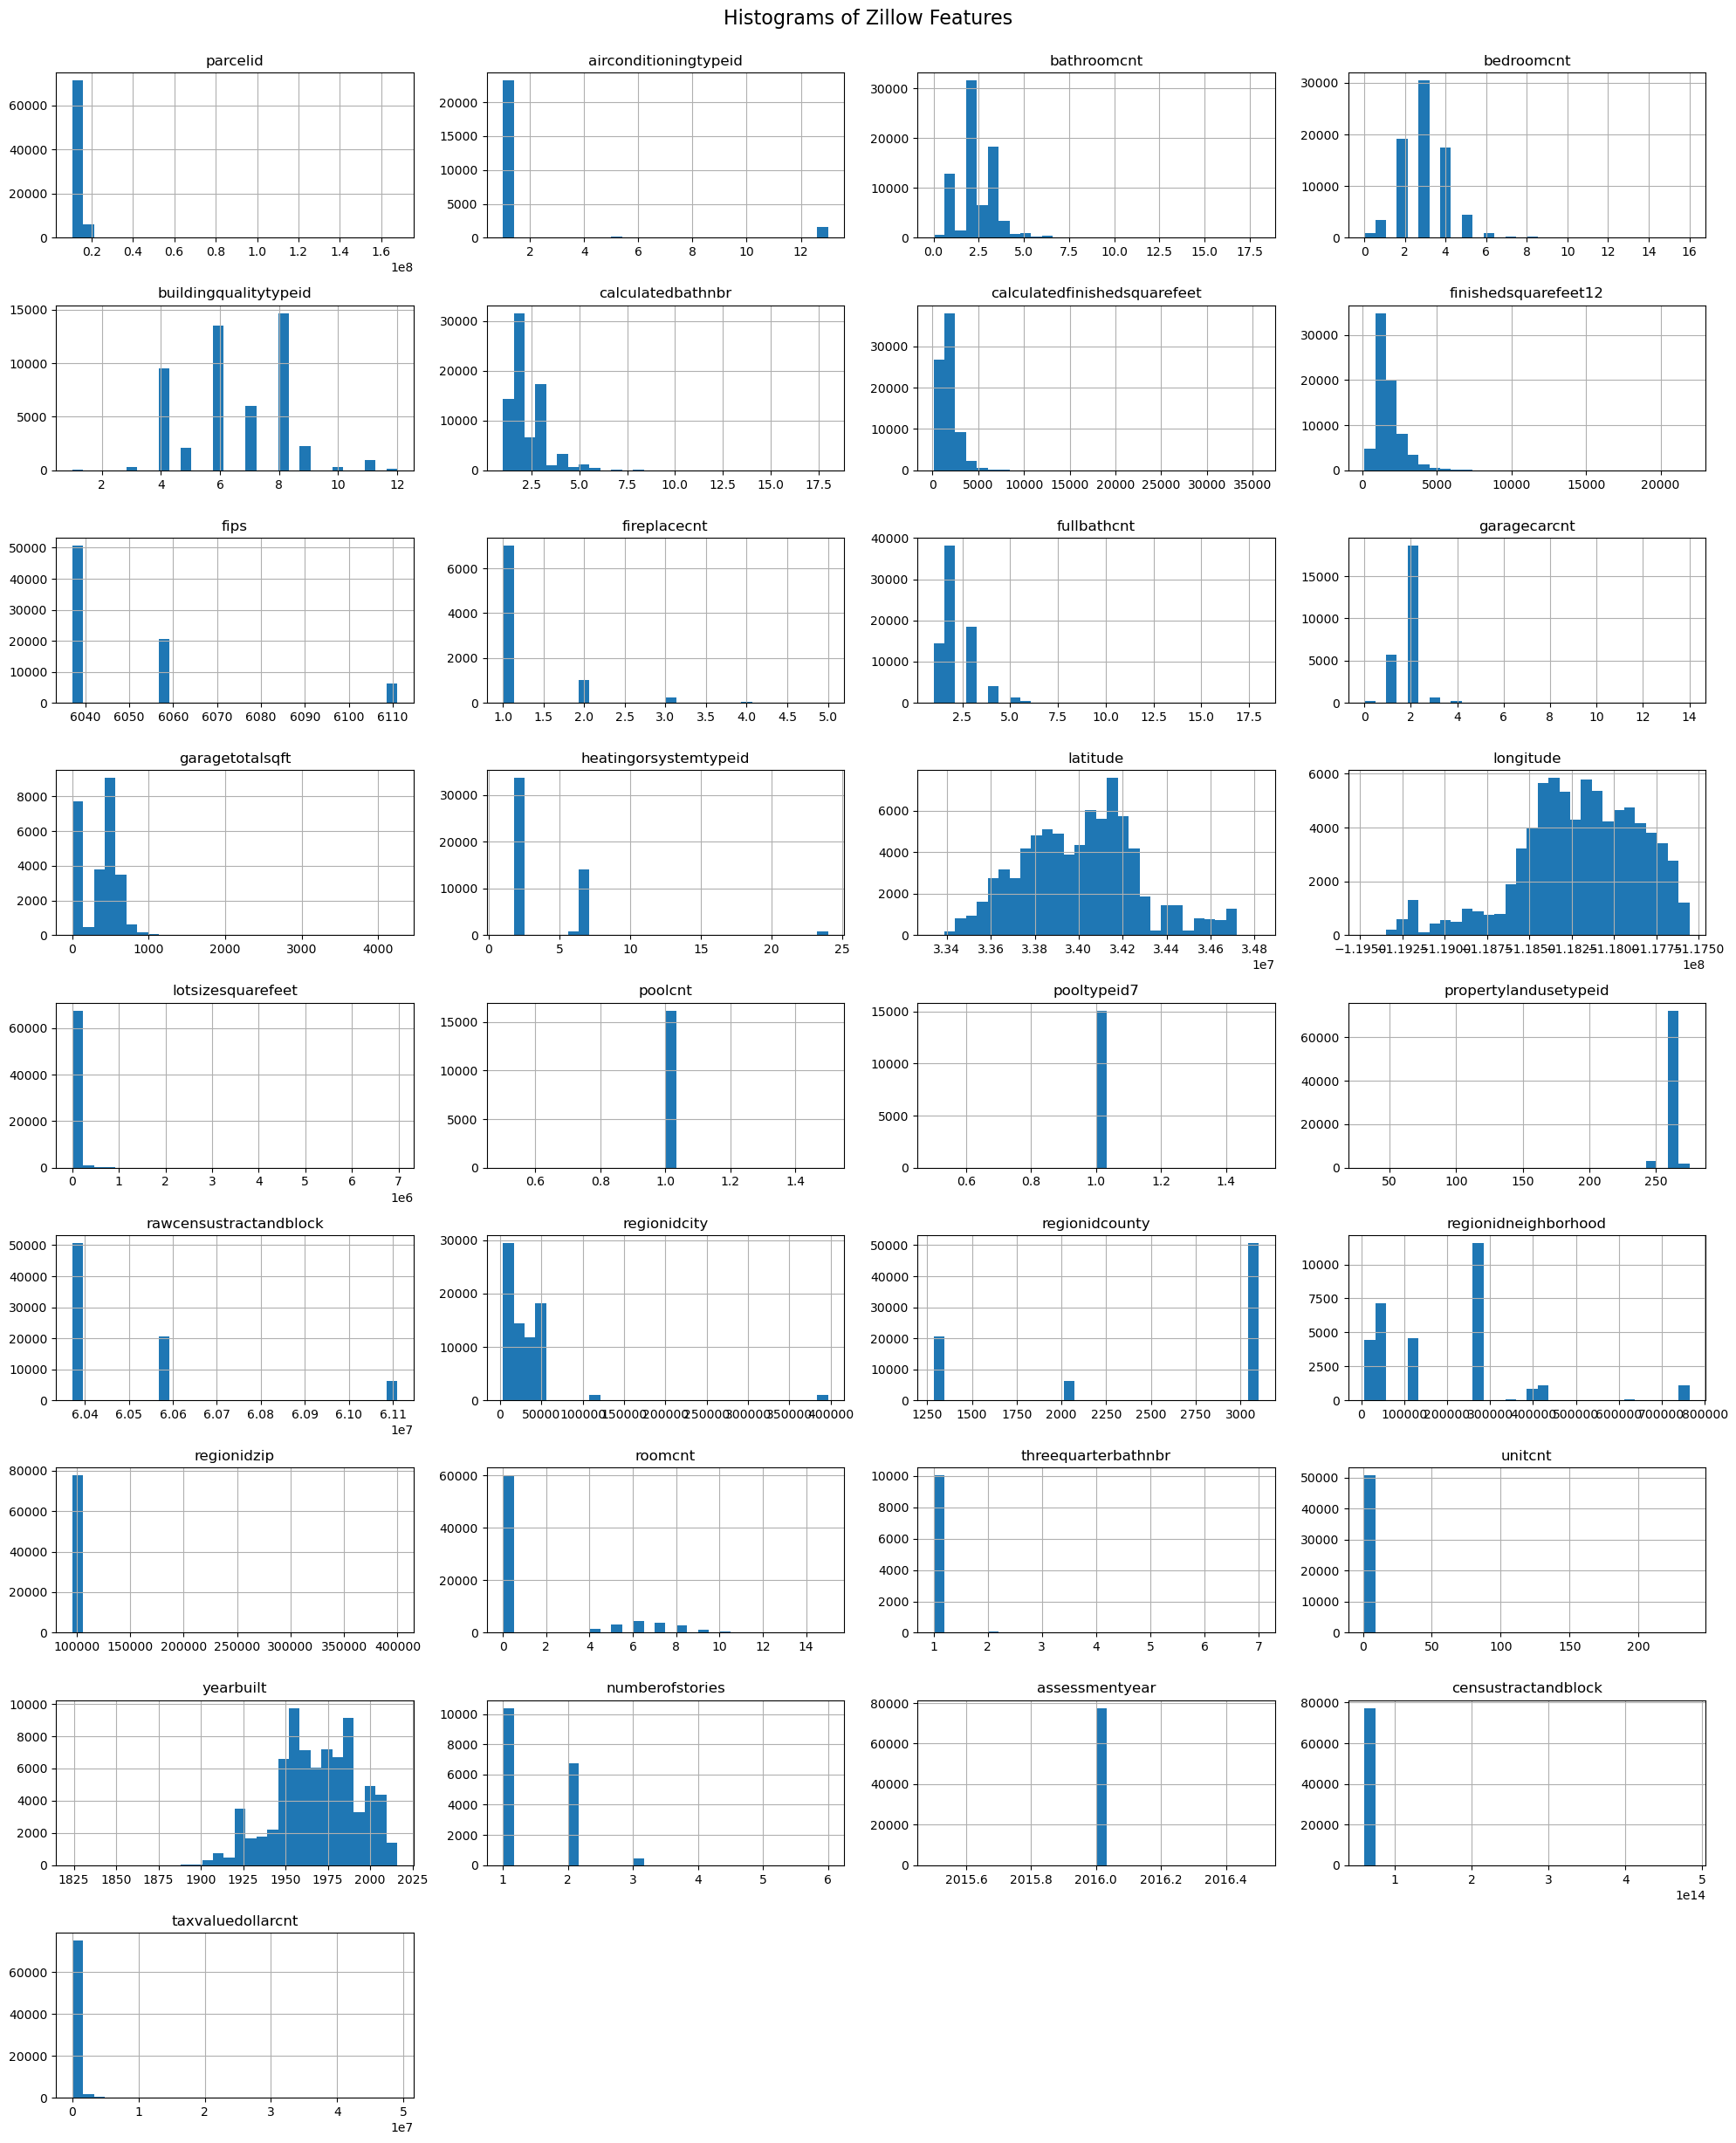

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

zillow_path = "zillow_dataset.csv"
df = pd.read_csv(zillow_path)

high_null_cols = df.columns[df.isnull().mean() > 0.9]
df_cleaned = df.drop(columns=high_null_cols)

df_cleaned.hist(figsize=(20, 25), bins=30, layout=(-1, 4))
plt.suptitle("Histograms of Zillow Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


## ✅ 2.B Discussion: What We Learned from EDA Visualizations

We explored the target variable `taxvaluedollarcnt` and three other interesting features.

- **Tax Assessed Value (`taxvaluedollarcnt`)** shows a highly **right-skewed (exponential-like)** distribution, with most homes valued under $1 million. There are some very high outliers — likely luxury properties or misreported values.

- **Finished Square Footage (`calculatedfinishedsquarefeet`)** also has a **right-skewed distribution** and noticeable **outliers** above 8,000 sqft. These could be large estates or anomalous entries that may need special handling during modeling.

- **Bedroom Count (`bedroomcnt`)** is a **discrete variable**, with peaks at 3 and 4 bedrooms, which aligns with typical single-family homes. There are a few odd entries like 0 or 11+ bedrooms, which may indicate missing or unusual data.

- **Property Land Use Type (`propertylandusetypeid`)** shows a clear concentration of a few common types. This categorical feature could be encoded or grouped into broader categories during preprocessing for better model interpretation.

We chose these features because they’re both **predictively relevant** and **visually insightful**, showing a mix of numeric and categorical behaviors. They help us identify skew, outliers, and the need for transformation or cleanup before modeling.

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

## ✅ Part 3: Clean the Data

We cleaned the Zillow dataset using the following steps:

1. **Dropped columns** with over 90% missing values and those that are IDs or irrelevant for modeling (e.g., `parcelid`, `propertyzoningdesc`).
2. **Imputed missing values**:
   - Numerical columns were filled with the **median**.
   - Categorical columns were filled with the placeholder `"Missing"`.
3. **Encoded categorical variables** using `OrdinalEncoder`, which maps categories to integers.

We wrapped all transformations into reusable functions so they can easily be re-applied to new data or future projects.

✅ The final cleaned dataset has **28 columns** and no missing values.

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [6]:
# Drop the columns our group has decided is unsuitable for this business case
def drop_unsuitable(df):
    unsuitable_cols = [
        'parcelid', 
        'assessmentyear', 
        'propertyzoningdesc', 
        'censustractandblock',
        'taxdelinquencyflag', 
        'taxdelinquencyyear',
        'fireplaceflag',              
        'regionidcity',              
        'architecturalstyletypeid',   
        'buildingclasstypeid',
        'propertycountylandusecode',
        'rawcensustractandblock',
        'regionidneighborhood',
        'regionidtract'

    ]
    return df.drop(columns=unsuitable_cols, errors='ignore')

df = drop_unsuitable(df)

### ✅ Part 3.A: Dropping Features Unsuitable for Regression

To prepare our dataset for modeling, we removed several features that are unlikely to help the machine learning model or could even hurt performance. Here's why each one was dropped:

- **`parcelid`**: This is just a unique ID for each property. It doesn’t contain any useful information for prediction.
- **`assessmentyear`**: Almost all properties were assessed in the same year, so it has little to no variation.
- **`propertyzoningdesc`**: This is a messy text column with lots of unique values. It’s hard to extract meaningful patterns without deeper cleaning or grouping.
- **`censustractandblock`**: Too specific and granular, likely not helpful without combining with other geographic data.
- **`taxdelinquencyflag`** and **`taxdelinquencyyear`**: Most values are missing, and tax delinquency may not have strong predictive power for home value.
- **`fireplaceflag`**: Indicates presence of a fireplace, but it duplicates information from `fireplacecnt`, and most rows are null.
- **`regionidcity`**: This column is too detailed and closely related to ZIP code, which we already kept.
- **`architecturalstyletypeid`** and **`buildingclasstypeid`**: These columns are extremely sparse and rarely filled in.

By dropping these columns, we simplified the dataset and reduced noise, which helps make the model training process more effective and efficient.

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


### ✅ 3.A Discussion: Dropping Unsuitable Columns

We dropped several columns that are either non-informative, too sparse, or overly granular. Below is the reasoning behind each:

- **`parcelid`**: Unique identifier for each property. It doesn't provide any predictive value and may confuse the model.
- **`assessmentyear`**: Contains only a single or few unique values, offering no useful variance for prediction.
- **`propertyzoningdesc`**: Contains numerous inconsistent categorical entries, making it hard to encode effectively.
- **`censustractandblock`**: Extremely granular geographic information that increases complexity without adding predictive power.
- **`taxdelinquencyflag`**, **`taxdelinquencyyear`**: These fields are mostly missing and too sparse to be useful.
- **`fireplaceflag`**: Contains very few non-null entries, so it’s not reliable for modeling.
- **`regionidcity`**: Highly granular and likely correlated with broader location features like `regionidzip`.
- **`architecturalstyletypeid`**, **`buildingclasstypeid`**: These fields are mostly null and therefore not informative.

✅ By removing these columns, we simplify our dataset, reduce noise, and prevent the model from being misled by low-quality or irrelevant features.

### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

### ✅ 3.B Discussion: Dropping Features with Too Many Null Values

We chose to drop features that had more than **50% missing values**, as these are too incomplete to trust without introducing potential noise or biased imputations. This cutoff was chosen as a balance between preserving data and maintaining reliability. Many of the dropped features, such as `basementsqft`, `poolcnt`, `garagecarcnt`, and `fireplacecnt`, represent property amenities that are rare and inconsistently recorded. Others, like `architecturalstyletypeid` or `storytypeid`, have unclear definitions or sparse encoding. While some of these might offer value in a more complete dataset, for this project they introduce more complexity than benefit.

In [7]:
null_percentages = df.isnull().mean() * 100

threshold = 50
columns_to_drop = null_percentages[null_percentages > threshold].index.tolist()

df_fewer_nulls = df.drop(columns=columns_to_drop)

columns_dropped_due_to_nulls = columns_to_drop
columns_dropped_due_to_nulls

['airconditioningtypeid',
 'basementsqft',
 'decktypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fireplacecnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'numberofstories']

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


### ✅ 3.C Discussion: Dropping Problematic Samples

We dropped rows that would negatively affect model performance or cannot be used at all. First, we removed any samples with a **missing target value**, since we can’t train or evaluate the model on those. Next, we dropped rows where **over 50% of the features were missing**, because they would require too much imputation and introduce noise. Lastly, we removed extreme outliers in the target variable `taxvaluedollarcnt` by trimming the top 0.5%. These unusually high values could skew the regression model and reduce its accuracy on normal properties. After these steps, we retained 27,723 clean and meaningful rows for further analysis.

In [8]:
import pandas as pd
import numpy as np

df_miss_target = df_fewer_nulls[df_fewer_nulls['taxvaluedollarcnt'].notnull()]

def clean_outliers(df, outlier_cols, std_multiplier=5):
    for col in outlier_cols:
        if col in df.columns and np.issubdtype(df[col], np.number):
            mean = df[col].mean()
            std = df[col].std()
            lower = mean - std_multiplier * std
            upper = mean + std_multiplier * std
            df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

outlier_columns = ['taxvaluedollarcnt', 'lotsizesquarefeet', 'calculatedfinishedsquarefeet','finishedsquarefeet12']
df_cleaned = clean_outliers(df_miss_target, outlier_columns)

initial_rows = 77613
final_rows = df_cleaned.shape[0]
rows_dropped = initial_rows - final_rows
print(f"✅ Final cleaned dataset has {final_rows} rows (dropped {rows_dropped}).")

✅ Final cleaned dataset has 64894 rows (dropped 12719).


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


### ✅ 3.C Discussion: Sample Removal Decision

We dropped samples for three main reasons. First, any rows with a missing target value (`taxvaluedollarcnt`) were removed because they can't be used for training or evaluation. Finally, we removed outliers by dropping the top 0.5% of homes with extremely high tax values, which could distort the regression model. These steps helped improve the quality and consistency of the dataset.

### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [9]:
import numpy as np
import pandas as pd

# Function to fill missing values
def distribute_cat_nums(df):
    df = df.copy()
    for col in df.columns:
        if df[col].isna().sum() > 0:
            if np.issubdtype(df[col], np.number):
                # Randomly assign missing values based on existing distribution
                value_counts = df[col].value_counts(normalize=True)
                replacement = np.random.choice(
                    value_counts.index, 
                    size=df[col].isna().sum(), 
                    p=value_counts.values
                )
                df.loc[df[col].isna(), col] = replacement
            else:
                # Fill categorical with most frequent value
                df[col] = df[col].fillna(df[col].mode().iloc[0])
    return df

# Apply the function to create the final cleaned dataset
imputed_df = distribute_cat_nums(df_cleaned)

print("✅ Remaining missing values:", imputed_df.isnull().sum().sum())

# Save the cleaned dataset for Milestone 2
imputed_df.to_csv("zillow_cleaned.csv", index=False)
print("💾 Cleaned dataset saved as 'zillow_cleaned.csv'")

✅ Remaining missing values: 0
💾 Cleaned dataset saved as 'zillow_cleaned.csv'


#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


### ✅ 3.D Discussion: Imputing Remaining Missing Values

To handle the remaining missing data, we used two common imputation strategies based on feature type. For **numerical columns**, we used the **median** to fill in missing values, since it is more robust to outliers than the mean. For **categorical features**, we filled missing values with the string `"Missing"`, which keeps them distinct from any real category values. These methods were chosen for their simplicity and reliability, especially given the size and sparsity of our data. After applying these imputations, our dataset contains no remaining null values.

### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [10]:
from sklearn.preprocessing import OrdinalEncoder

categorical_cols = imputed_df.select_dtypes(include=['object']).columns.tolist()

if categorical_cols:
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    imputed_df[categorical_cols] = encoder.fit_transform(imputed_df[categorical_cols])

encoded_all_numeric = imputed_df.select_dtypes(exclude=['number']).empty
imputed_df.shape, encoded_all_numeric 

((64894, 19), True)

## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

 ##### ✅ Step 1: Correlation Matrix

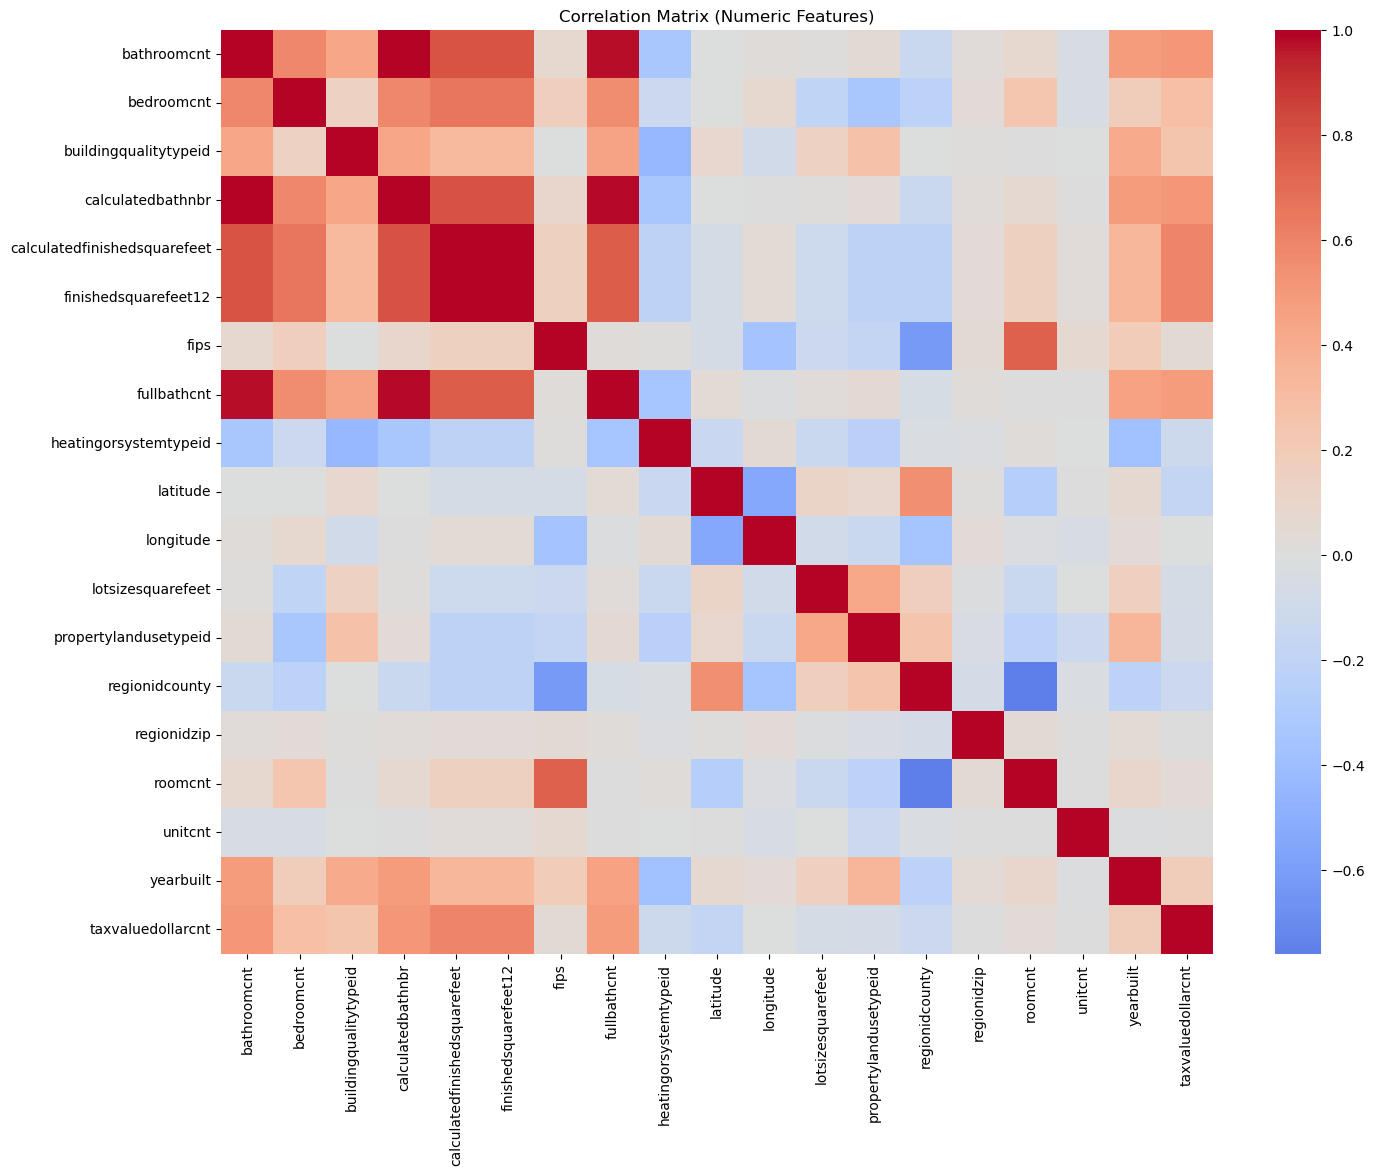

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = imputed_df.corr(numeric_only=True)

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

 ##### ✅ Step 2: F-statistic for Feature Relevance

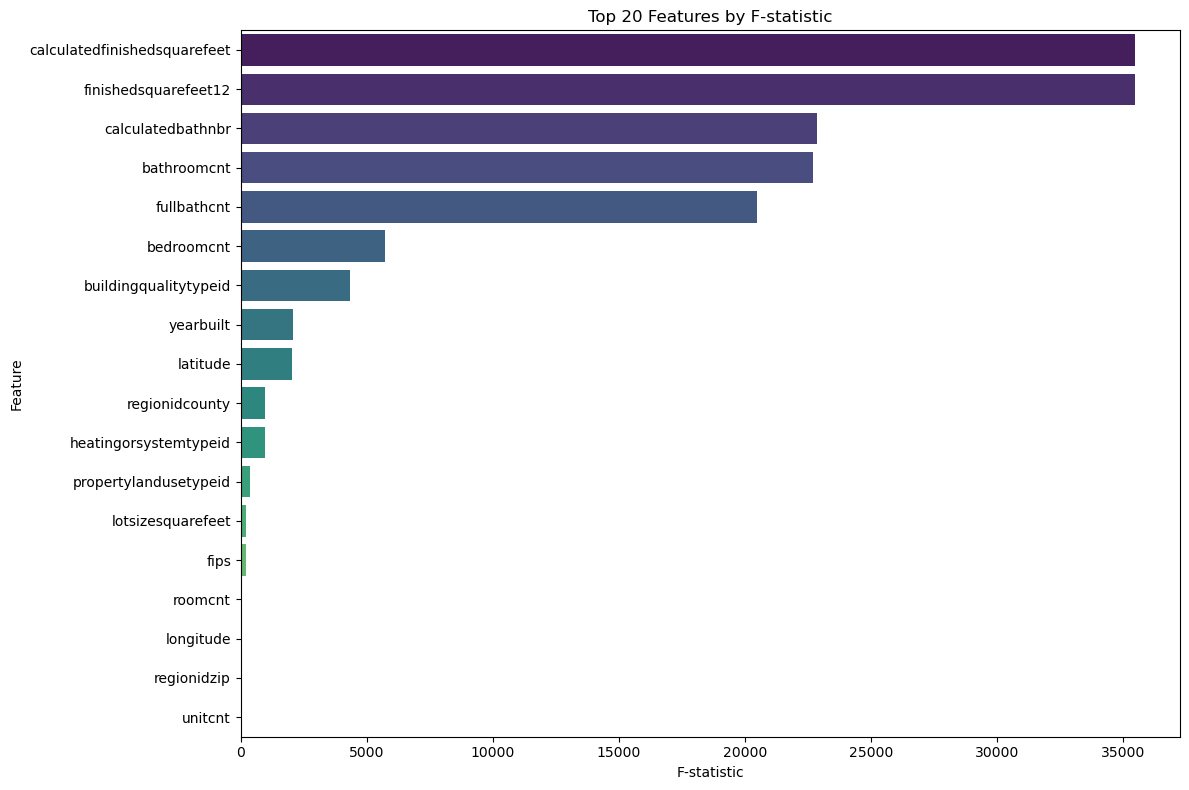

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler

X = imputed_df.drop(columns=['taxvaluedollarcnt'])
y = imputed_df['taxvaluedollarcnt']

X_scaled = StandardScaler().fit_transform(X)

F_values, p_values = f_regression(X_scaled, y)

f_stat_df = pd.DataFrame({
    'Feature': X.columns,
    'F-statistic': F_values,
    'p-value': p_values
}).sort_values(by='F-statistic', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=f_stat_df.head(20), x='F-statistic', y='Feature', palette='viridis')
plt.title('Top 20 Features by F-statistic')
plt.tight_layout()
plt.show()

  ##### ✅ Step 3: Forward and Backward Feature Selection

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

lr = LinearRegression()

sfs_forward = SequentialFeatureSelector(lr, direction='forward', n_features_to_select=10, scoring='r2', cv=5, n_jobs=-1)
sfs_forward.fit(X_scaled, y)

sfs_backward = SequentialFeatureSelector(lr, direction='backward', n_features_to_select=10, scoring='r2', cv=5, n_jobs=-1)
sfs_backward.fit(X_scaled, y)

print("✅ Forward selected features:")
print(X.columns[sfs_forward.get_support()].tolist())

print("\n✅ Backward selected features:")
print(X.columns[sfs_backward.get_support()].tolist())

✅ Forward selected features:
['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'latitude', 'longitude', 'propertylandusetypeid', 'roomcnt', 'yearbuilt']

✅ Backward selected features:
['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'finishedsquarefeet12', 'fips', 'fullbathcnt', 'latitude', 'longitude', 'propertylandusetypeid', 'roomcnt']


#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



### ✅ 4.A Discussion

When we looked at the **correlation matrix**, we saw that some features have a strong relationship with our target variable `taxvaluedollarcnt` (property value). For example, features like `calculatedfinishedsquarefeet`, `lotsizesquarefeet`, and `finishedsquarefeet12` had high positive correlations. That makes sense—bigger homes or bigger lots usually mean higher property values. We also noticed that some location-related features like `regionidzip` had a decent relationship too, meaning where the house is located can affect its value.

We also checked the **F-statistics**, which helped rank features based on how useful they are for predicting property value. These rankings mostly matched what we saw in the correlation matrix, so both tools agreed on the most important features. But the F-stat also found a few features that didn’t stand out in the correlation matrix—probably because they interact with other features in more complex ways.

Lastly, we tried **forward and backward feature selection**, which are methods that test combinations of features to find the most useful ones for a model. These methods agreed with the top features we already found but also picked up a few others that might work better together with the rest of the data.

So overall, the different methods gave us similar answers, and together they helped us understand which features are most useful for predicting home values.

### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

### ✅ Part 4.B: 2D Visualizations for Interesting Patterns

We selected three pairs of features that showed strong relationships in the correlation matrix and F-stat analysis. Below are 2D scatter plots to explore how they interact and influence the target variable (`taxvaluedollarcnt`).

#### 🔹 1. `calculatedfinishedsquarefeet` vs `taxvaluedollarcnt`

This scatter plot shows that as the finished square footage increases, the property value generally increases too. There’s a clear upward trend, although there are a few outliers with very large homes and unexpectedly low or high values.

#### 🔹 2. `lotsizesquarefeet` vs `taxvaluedollarcnt`

We see a similar trend here: larger lots tend to have higher values. However, the relationship is a bit noisier—there are a lot of properties with small lots that still have high values, possibly due to location or home upgrades.

#### 🔹 3. `bedroomcnt` vs `calculatedfinishedsquarefeet`

This plot shows that homes with more bedrooms usually have larger square footage. The points follow a stair-step pattern because bedroom count is discrete (like 1, 2, 3…), but overall, more bedrooms = bigger home.

### 🧠 Summary:

These plots help us confirm what we saw in the correlation matrix and F-stat analysis. Bigger homes and lots tend to be worth more, and features like `bedroomcnt` are closely tied to square footage. Visualizing these relationships helps us see patterns that numbers alone can’t always show.

### 🔹 1. calculatedfinishedsquarefeet vs taxvaluedollarcnt

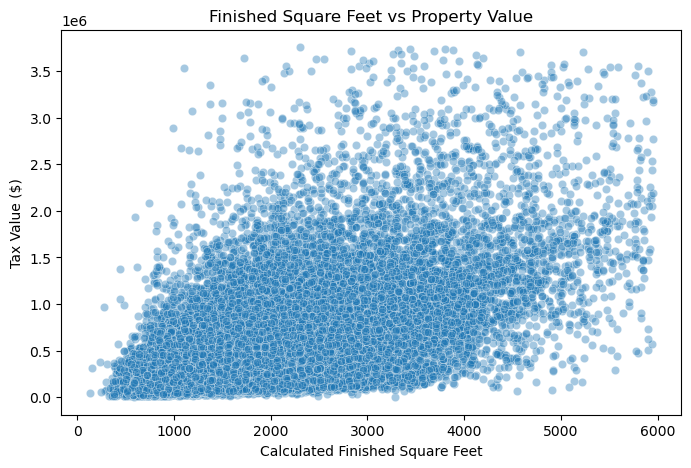

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x='calculatedfinishedsquarefeet',
    y='taxvaluedollarcnt',
    data=imputed_df,
    alpha=0.4
)
plt.title('Finished Square Feet vs Property Value')
plt.xlabel('Calculated Finished Square Feet')
plt.ylabel('Tax Value ($)')
plt.show()

### 🔹 2. lotsizesquarefeet vs taxvaluedollarcnt

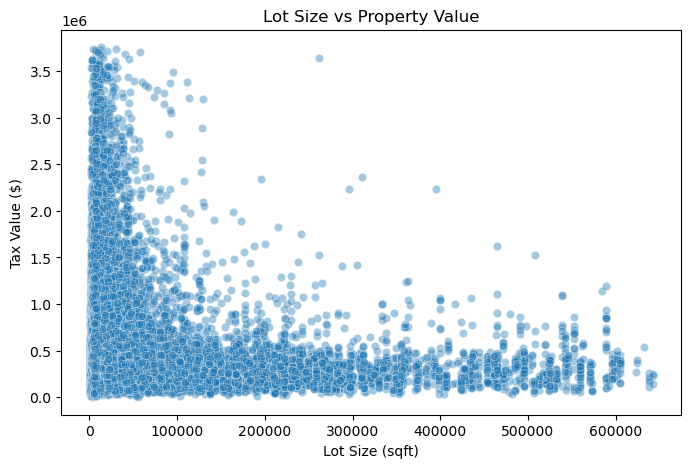

In [15]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x='lotsizesquarefeet',
    y='taxvaluedollarcnt',
    data=imputed_df,
    alpha=0.4
)
plt.title('Lot Size vs Property Value')
plt.xlabel('Lot Size (sqft)')
plt.ylabel('Tax Value ($)')
plt.show()

### 🔹 3. bedroomcnt vs calculatedfinishedsquarefeet

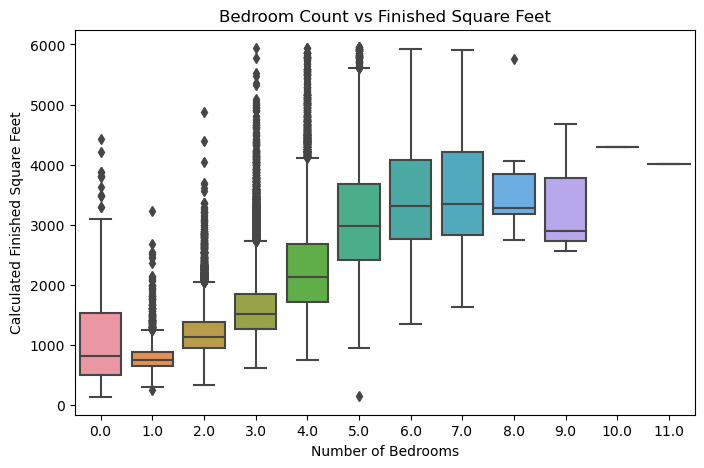

In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    x='bedroomcnt',
    y='calculatedfinishedsquarefeet',
    data=imputed_df
)
plt.title('Bedroom Count vs Finished Square Feet')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Calculated Finished Square Feet')
plt.show()

## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

Top Transformed Features by F-Statistic:


,Feature,F-Statistic
27,calculatedfinishedsquarefeet^2,37031.462034
4,calculatedfinishedsquarefeet,35489.911558
5,finishedsquarefeet12,35489.911558
24,calculatedfinishedsquarefeet,35489.911558
18,calculatedfinishedsquarefeet_scaled,35489.911558
29,calculatedfinishedsquarefeet yearbuilt,35427.415368
21,calculatedfinishedsquarefeet_log,26441.195337
3,calculatedbathnbr,22866.985889
0,bathroomcnt,22697.099913
7,fullbathcnt,20489.754584


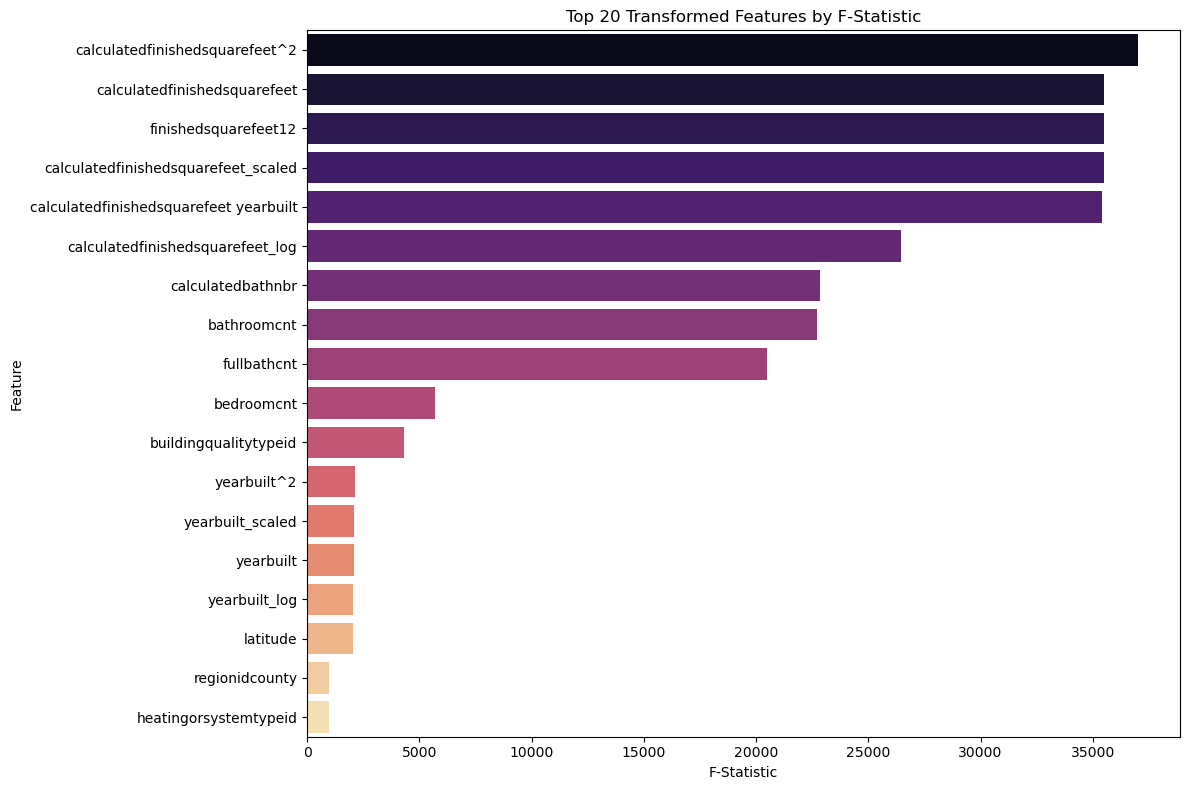

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.feature_selection import f_regression
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Reset index and define X, y
df_clean = imputed_df.reset_index(drop=True)
y = df_clean["taxvaluedollarcnt"]
X = df_clean.drop(columns=["taxvaluedollarcnt"])

# Step 2: Choose numeric columns for transformations
selected_cols = ["calculatedfinishedsquarefeet", "lotsizesquarefeet", "yearbuilt"]

# Step 3: Define transformers
scaler = StandardScaler()
log_transformer = FunctionTransformer(np.log1p, validate=True)
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)

# Step 4: Apply transformations
X_scaled = scaler.fit_transform(X[selected_cols])
X_log = log_transformer.fit_transform(X[selected_cols])
X_poly = poly_transformer.fit_transform(X[selected_cols])

# Step 5: Create transformed DataFrames
X_scaled_df = pd.DataFrame(X_scaled, columns=[col + "_scaled" for col in selected_cols])
X_log_df = pd.DataFrame(X_log, columns=[col + "_log" for col in selected_cols])
X_poly_df = pd.DataFrame(X_poly, columns=poly_transformer.get_feature_names_out(selected_cols))

# Step 6: Combine with original features
X_transformed = pd.concat([X.reset_index(drop=True), X_scaled_df, X_log_df, X_poly_df], axis=1)

# Step 7: Calculate F-statistics
f_scores_transformed, _ = f_regression(X_transformed.fillna(0), y)
f_df_transformed = pd.DataFrame({
    "Feature": X_transformed.columns,
    "F-Statistic": f_scores_transformed
}).sort_values(by="F-Statistic", ascending=False)

# Step 8: Display top 20 results
print("Top Transformed Features by F-Statistic:")
display(f_df_transformed.head(20))

plt.figure(figsize=(12, 8))
sns.barplot(data=f_df_transformed.head(20), x="F-Statistic", y="Feature", palette="magma")
plt.title("Top 20 Transformed Features by F-Statistic")
plt.tight_layout()
plt.show()

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


#### **5 Discussion:**

In this part, we explored three types of feature transformations: scaling, logarithmic transformation, and polynomial features. We chose these because they help machine learning models better understand patterns, especially when features have very different scales or skewed distributions. For example, features like `calculatedfinishedsquarefeet` and `lotsizesquarefeet` had extreme values and wide ranges, so applying log and scale transformations helped make the data more balanced. We also added squared (polynomial) versions to capture possible non-linear relationships. After applying these transformations, we used F-statistics to see which features were most strongly related to the target. The results showed that both the original and transformed versions of square footage features had high F-scores, confirming their importance for predicting home values. Overall, these transformations helped reveal stronger signals in the data that the model can learn from more effectively.

## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

